<a href="https://colab.research.google.com/github/omdena/earthquake/blob/master/Multi_Objective_Pathfinding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Under the Hood

### Install and import modules

In [0]:
#@title Run This!
import os, time
os.system('pip install geopandas ;apt install libspatialindex-dev; pip install rtree; pip install osmnx')
import osmnx as ox
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from itertools import count
from sklearn.preprocessing import normalize

### Set up the Map

In [0]:
#@ Choose place_name
place_name = "Fatih, Turkey" #@param {type:"string"}

In [0]:
class Map:
  """ Create a map object populated with streets and randomized profiles"""
  def __init__(self, place, seed = 42):
    """
    Parameters
    ----------
    place : str 
      name of location. Excample: 'Fatih, Istanbul, Turkey'
      OR list of adjacent names to be concatenated into a larger map

    Attributes
    -------
    self.graph: networkx.classes.multidigraph.MultiDiGraph
        graph of streets (edges) and intersections (nodes) of the area

    self.area: geopandas.geodataframe.GeoDataFrame
        contains the POLYGON bounding the entire area

    self.building: geopandas.geodataframe.GeoDataFrame
        contains the POLYGONS bounding the buildings in the area

    self.nodes_df: geopandas.geodataframe.GeoDataFrame
        contains the POINTS representing the intersections of streets in the area

    self.edges_df: geopandas.geodataframe.GeoDataFrame             
        contains the LINESTRINGS representing streets of the area
    """
    self.seed = seed

    if isinstance(place, str): 
      self.place_name = place
      # get graph data
      self.graph = ox.graph_from_place(self.place_name)
      self.graph = nx.relabel.convert_node_labels_to_integers(self.graph)
      # get the bounding area
      self.area = ox.gdf_from_place(self.place_name, buffer_dist= 50)
      # get information of buildings
      self.buildings = ox.footprints_from_place(self.place_name)
      # extract street data as nodes and edges
      self.nodes_df, self.edges_df = ox.graph_to_gdfs(self.graph)

    if isinstance(place, list):
      # get the bounding area
      self.area = ox.gdf_from_places(place, buffer_dist= 50)
      # get graph data
      self.graph = ox.graph_from_polygon(self.area.geometry.values[0])
      self.graph = nx.relabel.convert_node_labels_to_integers(self.graph)
      # get information of buildings
      self.buildings = ox.footprints_from_polygon(self.area.geometry.values[0])
      # extract street data as nodes and edges
      self.nodes_df, self.edges_df = ox.graph_to_gdfs(self.graph)
  
  def make_dummy_risk_data(self, max_risk = 5, percent_safe = 50, visualize_risk_on_map = True):
    """
    Parameters
    ----------
    max_risk : integer 
      largest risk level. Default = 5

    percent_safe : integer 
      percent of streets with 0 risk. Default = 50

    visualize_risk_on_map : boolean 
      plot map with risk values. Default = True
    
    Return
    -------
    self.graph: networkx.classes.multidigraph.MultiDiGraph
        modify edges of the graph and add risk_level attribute to each edge
    """
    np.random.seed(self.seed)
    self.edges_df['risk_rate'] = np.random.choice(np.arange(max_risk+1),len(self.edges_df), 
                                                  p=list(np.append(percent_safe/100, np.ones(max_risk)*((1-percent_safe/100)/max_risk))))
    #update self.graph with new self.edges_df
    self.graph = ox.gdfs_to_graph(self.nodes_df,self.edges_df)
    
    if visualize_risk_on_map:
      fig, ax = plt.subplots(figsize=(15, 10))
      self.area.plot(ax=ax, facecolor='gray')
      self.edges_df.plot(ax=ax, linewidth=2, column='risk_rate', cmap='seismic')
      self.nodes_df.plot(ax=ax, linewidth=2, facecolor='white')
      self.buildings.plot(ax=ax, facecolor='khaki', alpha=0.8)
      plt.colorbar(plt.cm.ScalarMappable(cmap='seismic'))
      plt.tight_layout()

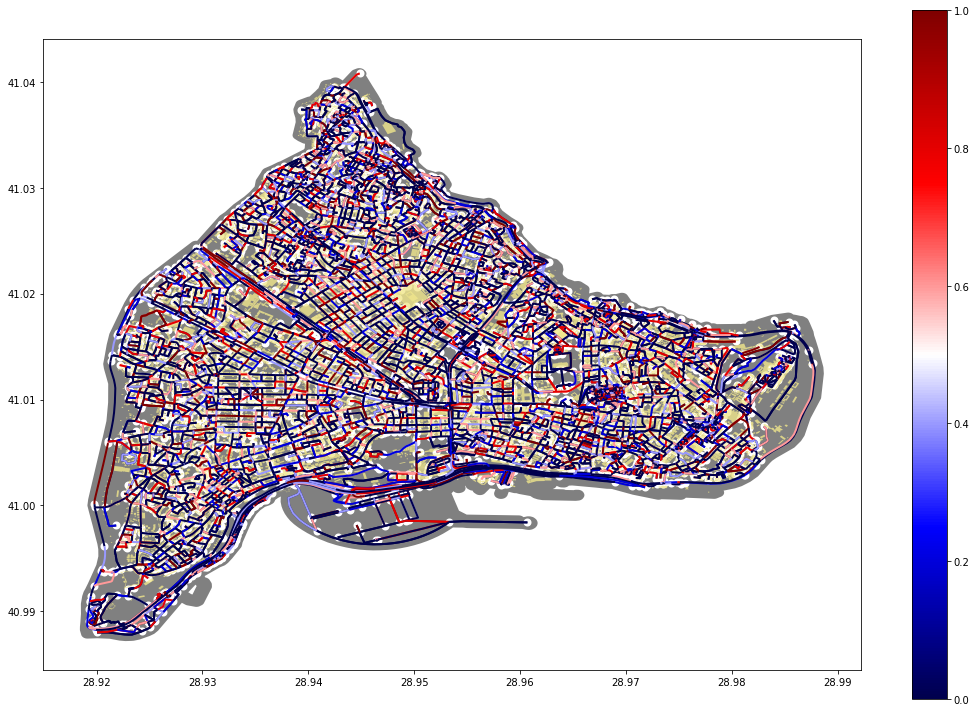

In [0]:
Map(place_name).make_dummy_risk_data()

### Modified A-star search: A-star search with Pareto front

In [0]:
# Original Authors: Salim Fadhley <salimfadhley@gmail.com>
#                   Matteo Dell'Amico <matteodellamico@gmail.com>
# Pareto component added by: Nguyen Tran <tranhoangnguyen03@gmail.com>
def astar_pareto_path(G, source, target, heuristic=None, weight='weight', weight_2='weight_2'):
    """Returns a list of nodes in a shortest path between source and target
    using the A* ("A-star") algorithm with a pareto-front check at every round.

    There may be more than one shortest path.  This returns only one.

    Parameters
    ----------
    G : NetworkX graph

    source : node
       Starting node for path

    target : node
       Ending node for path

    heuristic : function
       A function to evaluate the estimate of the distance
       from the a node to the target. The function takes
       two nodes arguments and must return a number. 

    weight: string, optional (default='weight')
       Edge data key corresponding to the edge PRIMARY weight.

    weight_2: string, optional (default='weight_2')
       Edge data key corresponding to the edge SECONDARY weight.

    Raises
    ------
    NetworkXNoPath
        If no path exists between source and target.

    Examples
    --------
    >>> G = nx.grid_graph(dim=[3, 3])  # nodes are two-tuples (x,y)
    >>> nx.set_edge_attributes(G, {e: e[1][0]*2 for e in G.edges()}, 'cost')
    >>> nx.set_edge_attributes(G, {e: e[1][0]**2 for e in G.edges()}, 'cost_2')
    >>> def dist(a, b):
    ...    (x1, y1) = a
    ...    (x2, y2) = b
    ...    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    >>> print(astar_pareto_path(G, (0, 0), (2, 2), heuristic=dist, weight='cost', weight_2='cost_2'))
    [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2)]

    """
    def is_pareto_efficient(costs):
        is_efficient = np.ones(costs.shape[0], dtype = bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
                is_efficient[i] = True  # And keep self
        return is_efficient

    if source not in G or target not in G:
        msg = 'Either source {} or target {} is not in G'
        raise nx.NodeNotFound(msg.format(source, target))

    if heuristic is None:
        # The default heuristic is h=0 - same as Dijkstra's algorithm
        def heuristic(u, v):
            return 0
    if heuristic == 'Eucledian':
        # The heuristic function for nx.graph whose nodes contains x and y coordinates
        # Euclidean distance between 2 points
        def heuristic(a, b):
            (x1, y1) = G.nodes[a]['x'],G.nodes[a]['y']
            (x2, y2) = G.nodes[b]['x'],G.nodes[b]['y']
            return ((x1 - x2)**2 + (y1 - y2)**2)**0.5
    
    if heuristic == 'Manhattan':
        # The heuristic function for nx.graph whose nodes contains x and y coordinates
        # Euclidean distance between 2 points
        def heuristic(a, b):
            (x1, y1) = G.nodes[a]['x'],G.nodes[a]['y']
            (x2, y2) = G.nodes[b]['x'],G.nodes[b]['y']
            return (np.absolute(x1 - x2) + np.absolute(y1 - y2))

    if heuristic == 'Chebyshev':
        # The heuristic function for nx.graph whose nodes contains x and y coordinates
        # Euclidean distance between 2 points
        def heuristic(a, b):
            (x1, y1) = G.nodes[a]['x'],G.nodes[a]['y']
            (x2, y2) = G.nodes[b]['x'],G.nodes[b]['y']
            return max(np.absolute(x1 - x2), np.absolute(y1 - y2))        

    push = heappush
    pop = heappop
    
    c = count()
    queue = [(0, next(c), source, 0, None)]

    enqueued = {}
    # Maps explored nodes to parent closest to the source.
    explored = {}
    
    while queue:
        # Pop the smallest item from queue.
        _, __, curnode, dist, parent = pop(queue)

        if curnode == target:
            path = [curnode]
            node = parent
            while node is not None:
                path.append(node)
                node = explored[node]
            path.reverse()
            return path

        if curnode in explored:
            # Do not override the parent of starting node
            if explored[curnode] is None:
                continue

            # Skip bad paths that were enqueued before finding a better one
            qcost, h, q_cost_2 = enqueued[curnode]
            if qcost < dist:
                continue

        explored[curnode] = parent
        scoreMatrix = {}
        for neighbor, w in G[curnode].items():
            ncost = dist + w.get(weight, 1)
            if neighbor in enqueued:
                qcost, h, ncost_2 = enqueued[neighbor]
                # if qcost <= ncost, a less costly path from the
                # neighbor to the source was already determined.
                # Therefore, we won't attempt to push this neighbor
                # to the queue
                if qcost <= ncost:
                    continue
            else:
                h = heuristic(neighbor, target)
                ncost_2 = w.get(weight_2, 1)
                # record the 3 costs for each neighbor: cost_1, heuristic_cost, and cost_2
                scoreMatrix[neighbor] = [ncost, h, ncost_2]

        # search for pareto front among neighbors, discard inefficient options
        if len(scoreMatrix) == 0: continue
        points = np.stack(list(scoreMatrix.values()))
        pareto_points = points[is_pareto_efficient(points)]
        pareto_neighbors = [key for key, value in scoreMatrix.items() if (value == pareto_points).all(1).any()]
        
        # normalize member(s) of pareto front then add to queue
        if not isinstance(target,tuple): 
            pareto_neighbors = np.hstack([np.array(pareto_neighbors).reshape(len(pareto_neighbors),1) ,
                                        normalize(np.stack([scoreMatrix[x] for x in pareto_neighbors]),axis=0),
                                        np.stack([scoreMatrix[x] for x in pareto_neighbors])])
            for neighbor_ in pareto_neighbors:
                neighbor_id, ncost_normed, h_normed, ncost_2_normed, ncost, h, ncost_2 = neighbor_
                enqueued[neighbor_id] = ncost, h, ncost_2
                push(queue, (ncost_normed + h_normed,
                             next(c), neighbor_id, ncost, curnode))
                
        else:
            len_ = len(neighbor)
            pareto_neighbors = np.hstack([pareto_neighbors, 
                                        normalize(np.stack([scoreMatrix[x] for x in pareto_neighbors]),axis=0),
                                        np.stack([scoreMatrix[x] for x in pareto_neighbors])])
            for neighbor_ in pareto_neighbors:
                neighbor_id = tuple([neighbor[i]for i in range(len_)])
                ncost_normed, h_normed, ncost_2_normed, ncost, h, ncost_2 = neighbor_[len_:]
                enqueued[neighbor_id] = ncost, h, ncost_2
                push(queue, (ncost_normed + h_normed, 
                             next(c), neighbor_id, ncost, curnode))
                
    raise nx.NetworkXNoPath("Node %s not reachable from %s" % (target, source))

### Path-finder module

In [0]:
class PathFinder(Map):
  """Given a place_name, start_node, end_node, return paths with different criteria"""
  def __init__(self, seed = 42):
    super().__init__(place = place_name)
    
    self.seed = seed


  def set_from_and_to(self, from_to = None):
    """
    Parameters
    ----------
    from_to : tuple or list
      if None then 2 random nodes are selected. Default = None

    Return
    -------
    self.from_, self.to_: integer
      extracted from parameter or randomly selected from available nodes
    """
    if from_to: 
      assert isinstance(from_to[0], int), 'FROM value needs to be integer'
      assert isinstance(from_to[1], int), 'TO value needs to be integer'
      self.from_ = from_to[0]
      self.to_ = from_to[1]
    else:   
      np.random.seed(self.seed)
      self.from_, self.to_ = np.random.choice(list(self.graph.nodes.keys()),2, replace= False)
    print(f'\rFROM node is set to Node({self.from_}); TO node is set to NODE({self.to_})',end='')  

  def find_shortest_path(self):
    """
    Return
    -------
    self.shortest_path: list
      list of nodes that make up the shortest path from self.from_ to self.to_
    self.shortest_path_length: float
      sum of length of edges found in shortest path  
    """
    self.error = 0
    try:
      self.shortest_path = nx.shortest_path(self.graph, self.from_, self.to_, weight='length')
    except nx.exception.NetworkXNoPath:
      self.error = 1
      print(f'\nCannot find shortest path from Node({self.from_}) to NODE({self.to_}) ')
      pass    
    self.shortest_path_length = sum(nx.Graph(self.graph)[u][v].get('length') for u, v in zip(self.shortest_path[:-1], self.shortest_path[1:]))
    self.shortest_path_risk = sum(nx.Graph(self.graph)[u][v].get('risk_rate') for u, v in zip(self.shortest_path[:-1], self.shortest_path[1:]))

  def find_safest_path(self):
    """
    Return
    -------
    self.safest_path: list
      list of nodes that make up the safest path from self.from_ to self.to_
    self.safest_path_length: float
      sum of length of edges found in safest path  
    """
    self.error = 0
    try:
      self.safest_path = nx.shortest_path(self.graph, self.from_, self.to_, weight='risk_rate')
    except nx.exception.NetworkXNoPath:
      self.error = 1
      print(f'\nCannot find safest path from Node({self.from_}) to NODE({self.to_}) ')
      pass
    self.safest_path_length = sum(nx.Graph(self.graph)[u][v].get('length') for u, v in zip(self.safest_path[:-1], self.safest_path[1:]))
    self.safest_path_risk = sum(nx.Graph(self.graph)[u][v].get('risk_rate') for u, v in zip(self.safest_path[:-1], self.safest_path[1:]))

  def find_optimal_path(self, primary = 'risk_rate', secondary = 'length', heuristic='Manhattan'):
    """
    Parameters
    ----------

    Return
    -------
    """
    
    self.error = 0
    try:
      self.optimal_path = astar_pareto_path(nx.Graph(self.graph), self.from_, self.to_,heuristic = heuristic, weight = primary, weight_2 = secondary)
    except nx.exception.NetworkXNoPath:
      self.error = 1
      print(f'\nCannot find optimal path from Node({self.from_}) to NODE({self.to_}) ')
      pass    
    self.optimal_path_length = sum(nx.Graph(self.graph)[u][v].get('length') for u, v in zip(self.optimal_path[:-1], self.optimal_path[1:]))
    self.optimal_path_risk = sum(nx.Graph(self.graph)[u][v].get('risk_rate') for u, v in zip(self.optimal_path[:-1], self.optimal_path[1:]))

  def visualize_path(self, path_sequences = None):
    """
    Parameters
    ----------
    path_sequences : Dictionary
      key = path name in string
      value = sequence of nodes in list 

    """
    """ TO BE FINISHED LATER """

path_finder = PathFinder()

### Generate data for evaluation

In [0]:
#@title Run random trials
heuristic_function = "Manhattan" #@param ["Manhattan",'Euclidean','Chebyshev','None']
number_of_trials = 200 #@param {type:"number"}
#@markdown *Note: pre-generated data is available next cell.

assert path_finder, "Please run the PathFinder cell to initiate the object"
results = pd.DataFrame()
if heuristic_function == 'None':  heuristic_function = None
for i in np.random.choice(np.arange(1000), number_of_trials, replace=False):
  path_finder.seed = i
  max_risk = np.random.choice(range(5,15,1),1)
  percent_safe = np.random.choice(range(10,80,10),1)
  path_finder.make_dummy_risk_data(max_risk = max_risk, percent_safe = percent_safe, visualize_risk_on_map = False)
  path_finder.set_from_and_to() # blank means random and uses seed i provided above
  
  start = time.time()
  path_finder.find_shortest_path()
  if path_finder.error == 0:
    results = results.append({"From_To":str(path_finder.from_)+'-'+str(path_finder.to_), 
                            'Path_choice': 'dijkstra_shortest', 
                            'Total_risk': path_finder.shortest_path_risk, 
                            'Total_length': path_finder.shortest_path_length,
                            'Num_Nodes_visited': len(path_finder.shortest_path),
                            'Path_taken': path_finder.shortest_path,
                            'Compute_time': time.time()-start,
                            'Risk_profile': (max_risk, percent_safe)},
                          ignore_index=True)
    
  start = time.time()
  path_finder.find_safest_path()
  if path_finder.error == 0:
    results = results.append({"From_To":str(path_finder.from_)+'-'+str(path_finder.to_), 
                              'Path_choice': 'dijkstra_safest', 
                              'Total_risk': path_finder.safest_path_risk, 
                              'Total_length': path_finder.safest_path_length,
                              'Num_Nodes_visited': len(path_finder.safest_path),
                              'Path_taken': path_finder.safest_path,
                              'Compute_time': time.time()-start,
                            'Risk_profile': (max_risk, percent_safe)},
                            ignore_index=True)
  
  start = time.time()
  path_finder.find_optimal_path(primary='risk_rate', secondary='length')
  if path_finder.error == 0:
    results = results.append({"From_To":str(path_finder.from_)+'-'+str(path_finder.to_), 
                            'Path_choice': 'A_star_Pareto_risk_rate_primary', 
                            'Total_risk': path_finder.optimal_path_risk, 
                            'Total_length': path_finder.optimal_path_length,
                            'Num_Nodes_visited': len(path_finder.optimal_path),
                            'Path_taken': path_finder.optimal_path, 
                            'Compute_time': time.time()-start,
                            'Risk_profile': (max_risk, percent_safe)},
                          ignore_index=True)
  
  start = time.time()
  path_finder.find_optimal_path(primary = 'length', secondary = 'risk_rate', heuristic = heuristic_function)
  if path_finder.error == 0:
    results = results.append({"From_To":str(path_finder.from_)+'-'+str(path_finder.to_), 
                            'Path_choice': 'A_star_Pareto_length_primary', 
                            'Total_risk': path_finder.optimal_path_risk, 
                            'Total_length': path_finder.optimal_path_length,
                            'Num_Nodes_visited': len(path_finder.optimal_path),
                            'Path_taken': path_finder.optimal_path, 
                            'Compute_time': time.time()-start,
                            'Risk_profile': (max_risk, percent_safe)},
                          ignore_index=True) 
    
filename = 'temp_data.pickle'
results.to_pickle(filename)    

# Results Analysis

In [150]:
#@title Summary Tables
if not filename:
  filename = '1270_samples_astar_pareto.pickle'
  os.system('wget -O key.json https://storage.googleapis.com/props.davidustranus.space/key.json')
  os.system('gcloud auth activate-service-account --key-file=key.json')
  os.system('gcloud config set project python-on-cloud')
  os.system(f'gsutil cp gs://public_bucket_poc/Multi_Objective_Pathfinding/{filename} .')

from IPython.core.display import HTML

results = pd.read_pickle(filename)

display(HTML('<h3>Data description</h3>'))
display(results.describe().loc[['count','mean','std']])

pivoted = results.pivot_table(values=['Total_length','Total_risk'],aggfunc='mean',columns='Heuristic',index='Path_choice')
_ = round(pivoted/pivoted.min()*100,2)
display(HTML('<br> </br><h3>Data Summary</h3>'))
display(_)


results['max_risk'] = results.Risk_profile.apply(lambda x: x[0][0])
results['safe_percent'] = results.Risk_profile.apply(lambda x: x[1][0])
results_ = results.copy()
results_['trial'] = results.apply(lambda x: f'{x.From_To}_{x.max_risk}_{x.safe_percent}',axis=1)

safest_count = {}
safest_count['Dijkstra_safest'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'dijkstra_safest') & (x.Total_risk == x.Total_risk.min())).sum()
safest_count['Dijkstra_shortest'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'dijkstra_shortest') & (x.Total_risk == x.Total_risk.min())).sum()
safest_count['A*_Pareto_risk_primary'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'A_star_Pareto_risk_rate_primary') & (x.Total_risk == x.Total_risk.min())).sum()
safest_count['A*_Pareto_length_primary'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'A_star_Pareto_length_primary') & (x.Total_risk == x.Total_risk.min())).sum()
safest_count['Counts multiple min risks'] = results_.groupby('trial').apply(lambda x: np.sum(x.Total_risk == x.Total_risk.min())-1).sum()

shortest_count = {}
shortest_count['Dijkstra_safest'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'dijkstra_safest') & (x.Total_length == x.Total_length.min())).sum()
shortest_count['Dijkstra_shortest'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'dijkstra_shortest') & (x.Total_length == x.Total_length.min())).sum()
shortest_count['A*_Pareto_risk_primary'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'A_star_Pareto_risk_rate_primary') & (x.Total_length == x.Total_length.min())).sum()
shortest_count['A*_Pareto_length_primary'] = results_.groupby('trial').apply(lambda x: (x.Path_choice == 'A_star_Pareto_length_primary') & (x.Total_length == x.Total_length.min())).sum()
shortest_count['Counts multiple min length'] = results_.groupby('trial').apply(lambda x: np.sum(x.Total_length == x.Total_length.min())-1).sum()

count_mins = round(pd.DataFrame([shortest_count,safest_count]).T/results_.trial.nunique()*100,2)
count_mins.rename(columns={0:'% Achieving min length',1:'% Achieving min risks'}, inplace=True)
display(HTML('<br> </br><h3>Percent times an algorithm minimizing an attribute</h3>'))
display(count_mins)

,Compute_time,Num_Nodes_visited,Total_length,Total_risk
count,4601.000000,4601.000000,4601.000000,4601.000000
mean,13.351047,61.314497,3895.366277,162.544230
std,7.526028,33.355138,2297.704659,119.660724


Total_length            ... Total_risk          
Heuristic                          Chebyshev Euclidean  ...  Euclidean Manhattan
Path_choice                                             ...                     
A_star_Pareto_length_primary          132.06    133.73  ...     139.09    139.24
A_star_Pareto_risk_rate_primary       136.75    138.29  ...     118.63    120.81
dijkstra_safest                       170.45    175.64  ...     100.00    100.00
dijkstra_shortest                     100.00    100.00  ...     134.06    133.25

[4 rows x 6 columns]

,% Achieving min length,% Achieving min risks
Dijkstra_safest,0.52,59.55
Dijkstra_shortest,92.05,10.11
A*_Pareto_risk_primary,5.88,28.69
A*_Pareto_length_primary,6.66,9.16
Counts multiple min length,5.10,NaN
Counts multiple min risks,NaN,7.52


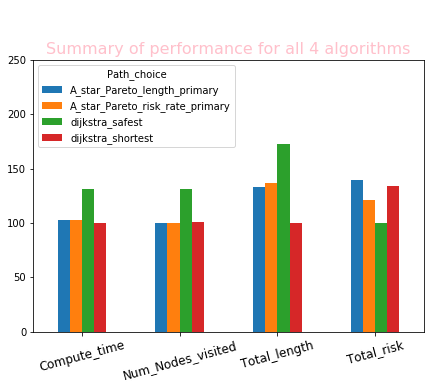

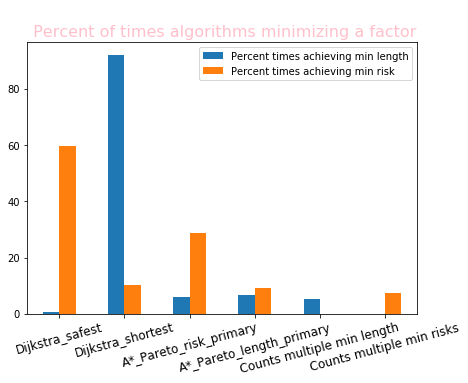

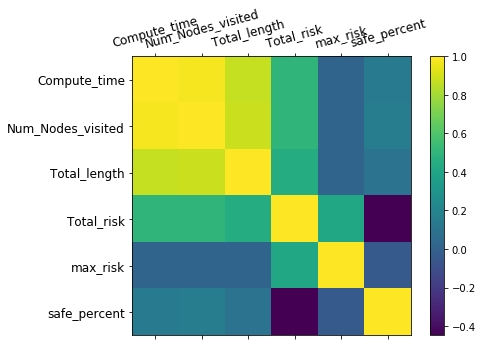

In [151]:
#@title Summary Graphs
ax = round(results.groupby('Path_choice').mean()/results.groupby('Path_choice').mean().min()*100,2)[['Compute_time',	'Num_Nodes_visited',	'Total_length',	'Total_risk']].T.plot(kind='bar', figsize = (7,5))
plt.title('\n\nSummary of performance for all 4 algorithms', fontsize=16, color='pink')
plt.ylim(top=250)
plt.xticks(rotation=15, fontsize=12)
plt.show()

components = ['Compute_time',	'Num_Nodes_visited',	'Total_length',	'Total_risk',	'max_risk',	'safe_percent']
results_[components] = normalize(results[components], axis=0)

count_mins.plot(kind='bar', figsize = (7,5))
plt.legend(['Percent times achieving min length','Percent times achieving min risk'])
plt.title('\n Percent of times algorithms minimizing a factor', fontsize=16, color='pink')
plt.xticks(rotation=15, fontsize=12)
plt.show()

plt.figure(figsize = (7,5))
plt.matshow(results_.corr(), fignum=1)
plt.xticks(range(0,len(components)), components, fontsize=12, rotation=15)
plt.yticks(range(0,len(components)), components, fontsize=12)
plt.colorbar()
plt.show()

The results after running 1270 trials are the following:


1.   Compute_time and Num_Nodes_visited are correlated, more path options to evaluate (a.k.a larger maps) will lead to more computation overheads. Complex map configurations with complex risk distribution will increase computational complexity.

2.   In trying to minimize risks taken, Risk-weighted Dijkstra is the most picky algorithm, thus traveling the longest distance (on average, 70% - 75% longer than Length-weighted Dijkstra), covering the most number of nodes and requires the most computation. Risk-weighted Dijkstra does produce the safest path most often (60% of all trials).

3.   In trying to minimize the travel distance, Length-weighted Dijkstra is consistently produces the shortest path on average and in frequency (92% of all trials) at the expense of risks (on average, 33% - 34% more risk than Risk-weighted Dijkstra).

4.   In trying to balance the two criteria, by eliminating all node options that are not pareto-efficient, A* Pareto tries to make compromises between two criteria. However, only when risk_rate is set as the primary factor (length being secondary) does the algorithm seems to work. This holds true across all 3 choices of common heuristic functions (L1-Manhattan, L2-Euclidean, and Lmax-Chebyshev) --- It might be the case that the Heuristic function already serves half-well as an estimation of distance from target, so having length as primary factor provides signals that are not only redundant but perhaps even conflicting.

---> Overall, A* Pareto with risk_rate as the primary weight seems to be the best choice for our particular problem managing to make a reasonable compromise in path length (on average, 37%-38% extra vs.70%-75% extra) and in risks taken (on average,18%-24% extra vs.33%-34% extra). Note also that A* Pareto with risk_rate as the primary weight also out-perform/on-par with Risk-weighted Dijkstra nearly 30% of the time.

